In [1]:
%load_ext autoreload
%autoreload 2
from etr.auto_import import *
from etr.data.data_loader import load_data

## Data
---

In [2]:
# rate = load_data(["2025-05-01", "2025-05-19"], table="Rate", venue="*", symbol="BTCJPY")

In [3]:
trade = pd.concat([
    load_data(["2025-05-01", "2025-05-19"], table="MarketTrade", venue="*", symbol="BTCJPY"),
    load_data(["2025-05-01", "2025-05-19"], table="MarketTrade", venue="*", symbol="XBTUSD"),
])
trade["term_amount"] = trade.amount * trade.price / 1e6
trade["latency"] = (trade["timestamp"] - trade.market_created_timestamp).dt.total_seconds() * 1e3

2025-05-18 02:03:38.797|INFO    |etr.data.data_loader: data_loader.load_data 85|Found 63 HDB files, process loading...
100%|██████████| 63/63 [00:00<00:00, 84.53it/s] 
2025-05-18 02:03:39.879|INFO    |etr.data.data_loader: data_loader.load_data 85|Found 16 HDB files, process loading...
100%|██████████| 16/16 [00:00<00:00, 39.12it/s]


In [4]:
rate = load_data(["2025-05-01", "2025-05-19"], table="Rate", venue="*", symbol="USDJPY")

2025-05-18 02:03:41.480|INFO    |etr.data.data_loader: data_loader.load_data 85|Found 14 HDB files, process loading...
100%|██████████| 14/14 [00:01<00:00, 13.09it/s]


## Analysis
---

- latency
- volume
- lead-lag
- 乖離

### latency

In [5]:
(
    trade
    .groupby([trade.market_created_timestamp.dt.hour, "venue"]).latency.median()
    .unstack(level=-1).astype(int)
    .style.format(precision=2).bar()
)

venue,bitbank,bitflyer,bitmex,coincheck,gmo
market_created_timestamp,,,,,
0,589,83,148,634,14
1,603,83,148,632,14
2,595,81,147,631,14
3,599,79,147,634,15
4,617,78,145,626,13
5,620,78,147,632,14
6,607,79,147,621,13
7,611,86,149,645,16
8,603,83,150,641,15


In [6]:
trade.groupby("venue").latency.describe().style.format(precision=1)

,count,mean,std,min,25%,50%,75%,max
venue,,,,,,,,
bitbank,172939.0,608.4,304.4,42.5,352.1,605.5,856.2,2713.4
bitflyer,499020.0,98.4,71.8,12.7,67.0,81.6,107.8,13076.9
bitmex,1059209.0,163.1,173.8,111.1,143.6,150.3,161.4,137263.2
coincheck,457999.0,693.8,645.1,30.3,392.4,636.1,889.7,24555.4
gmo,467584.0,25.5,199.9,-18.5,11.6,14.7,20.9,16452.4


- BF, Mex, GMOは東京っぽい
- GMOは同期がとれていない

---

### volume

In [7]:
trade.set_index("market_created_timestamp").groupby(["venue", "sym"]).resample("10min").term_amount.sum().unstack(level=[0, 1]).describe().T.sort_values("mean")

,,count,mean,std,min,25%,50%,75%,max
venue,sym,,,,,,,,
bitmex,XBTUSD,2304.0,2.582530,3.387656,0.010700,1.020301,1.622749,2.740026,43.610794
bitbank,BTCJPY,2304.0,21.161054,30.613025,0.000000,4.428488,11.174059,25.351887,391.554291
gmo,BTCJPY,2220.0,44.155730,52.922941,0.000000,17.057122,29.332220,50.457519,1033.428933
coincheck,BTCJPY,2069.0,68.834864,75.435587,0.176106,24.027844,47.379985,89.792613,1190.919263
bitflyer,BTCJPY,2304.0,81.340345,101.435905,0.000000,22.563363,48.791665,103.683898,1803.550423


### lead-lag

In [8]:
close = trade.set_index("market_created_timestamp").groupby(["venue", "sym"]).price.resample("10s", label="right").last().unstack(level=[0, 1]).ffill()

In [9]:
# 10 sec return
close.pct_change().mul(1e4).describe().T

,,count,mean,std,min,25%,50%,75%,max
venue,sym,,,,,,,,
bitbank,BTCJPY,138238.0,0.008291,1.542264,-42.636930,0.000000,0.0,0.000000,43.178267
bitflyer,BTCJPY,138239.0,0.008479,2.346956,-35.969806,-0.069137,0.0,0.131646,44.233002
bitmex,XBTUSD,138239.0,0.006995,1.931818,-47.908271,-0.410102,0.0,0.480134,50.846933
coincheck,BTCJPY,124132.0,0.005756,2.016242,-40.510208,-0.315721,0.0,0.358872,41.233778
gmo,BTCJPY,133159.0,0.006174,2.257979,-47.522404,-0.441367,0.0,0.457564,55.097987


In [10]:
# correlation
close.corr()

,venue,bitbank,bitflyer,bitmex,coincheck,gmo
,sym,BTCJPY,BTCJPY,XBTUSD,BTCJPY,BTCJPY
venue,sym,,,,,
bitbank,BTCJPY,1.000000,0.999859,0.988399,0.999887,0.999774
bitflyer,BTCJPY,0.999859,1.000000,0.988641,0.999937,0.999896
bitmex,XBTUSD,0.988399,0.988641,1.000000,0.987396,0.988340
coincheck,BTCJPY,0.999887,0.999937,0.987396,1.000000,0.999841
gmo,BTCJPY,0.999774,0.999896,0.988340,0.999841,1.000000


In [11]:
# lead lag corr
ret = close.pct_change().mul(1e4)
ret.columns = ["HIST_"+"_".join(c) for c in ret.columns.values]
fwd_ret = ret.shift(-1).rename(lambda x: f"{x}".replace("HIST_", "FWD_"), axis=1)

corr = ret.join(fwd_ret).corr()
corr.loc[corr.columns.str.contains("HIST"), corr.columns.str.contains("FWD")].style.background_gradient(vmin=-0.3, vmax=0.3, cmap="RdBu")

,FWD_bitbank_BTCJPY,FWD_bitflyer_BTCJPY,FWD_bitmex_XBTUSD,FWD_coincheck_BTCJPY,FWD_gmo_BTCJPY
HIST_bitbank_BTCJPY,0.091179,0.048147,-0.002937,0.022107,0.011598
HIST_bitflyer_BTCJPY,0.219357,-0.052967,0.056968,0.077578,0.066086
HIST_bitmex_XBTUSD,0.279092,0.164697,0.035055,0.116443,0.098789
HIST_coincheck_BTCJPY,0.262705,0.153235,0.084811,-0.009785,0.091756
HIST_gmo_BTCJPY,0.246176,0.158585,0.090206,0.104131,-0.046662


----
### deviation (from bitbank)

In [12]:
# from GMO
dev = close.drop("bitmex", axis=1).div(close[["gmo"]].values).sub(1).drop("gmo", axis=1).dropna().mul(1e4)

In [13]:
dev.describe().T

,,count,mean,std,min,25%,50%,75%,max
venue,sym,,,,,,,,
bitbank,BTCJPY,124133.0,10.877843,11.103392,-44.244968,3.130791,11.947688,19.339611,51.509211
bitflyer,BTCJPY,124133.0,8.523141,8.121767,-43.988541,2.788005,8.388331,13.891610,39.645029
coincheck,BTCJPY,124133.0,12.125893,10.048459,-39.718939,5.459802,12.156415,18.652351,43.613767


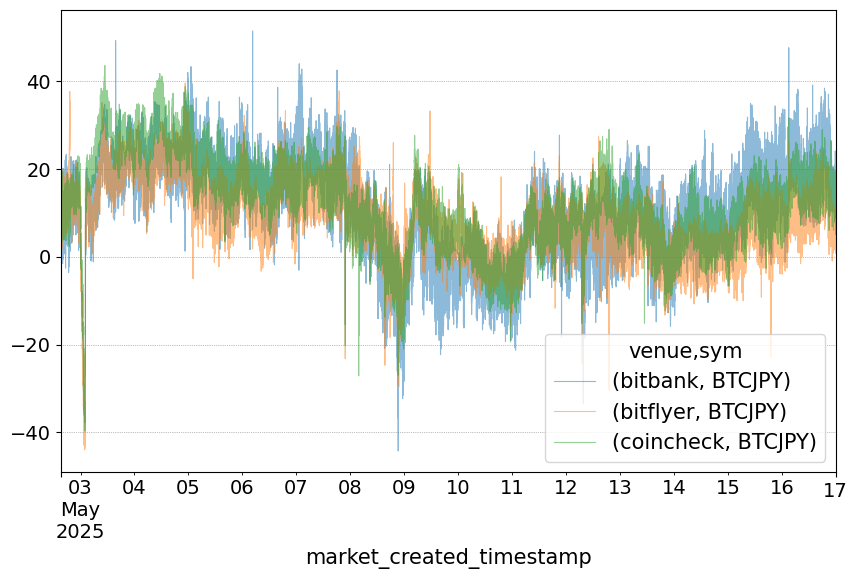

In [14]:
dev.plot(alpha=0.5);

In [196]:
# autocorrlation of Diff(Deviation)
for freq in [10, 60, 120, 180, 300, 600, 1200]:
    dev2 = dev.resample(f"{freq}s", label="right").last().diff().dropna()
    dev2 = dev2.set_axis(["_".join(c) for c in dev2.columns], axis=1)
    display(
        f"{freq}s",
        pd.concat([dev2.apply(lambda x: x.autocorr(lag)).rename(lag) for lag in np.arange(1, 5)], axis=1).T.style.bar()
    )

'10s'

,bitbank_BTCJPY,bitflyer_BTCJPY,coincheck_BTCJPY
1,-0.167915,-0.295931,-0.311194
2,-0.083218,-0.091216,-0.086681
3,-0.050616,-0.048943,-0.031657
4,-0.035788,-0.021250,-0.025118


'60s'

,bitbank_BTCJPY,bitflyer_BTCJPY,coincheck_BTCJPY
1,-0.332926,-0.435520,-0.414782
2,-0.056327,-0.036247,-0.032211
3,-0.041945,0.009341,-0.011555
4,-0.021314,-0.018478,0.007125


'120s'

,bitbank_BTCJPY,bitflyer_BTCJPY,coincheck_BTCJPY
1,-0.362550,-0.429219,-0.415203
2,-0.060399,-0.028969,-0.001247
3,-0.030420,-0.000494,-0.022208
4,-0.013860,-0.004989,-0.005250


'180s'

,bitbank_BTCJPY,bitflyer_BTCJPY,coincheck_BTCJPY
1,-0.399715,-0.421995,-0.400782
2,-0.046763,-0.005437,-0.015740
3,-0.011619,-0.039360,-0.003365
4,-0.004881,0.019699,-0.008347


'300s'

,bitbank_BTCJPY,bitflyer_BTCJPY,coincheck_BTCJPY
1,-0.399692,-0.409889,-0.362327
2,-0.057837,-0.030824,-0.040520
3,0.002364,-0.023906,-0.008031
4,-0.007234,0.018005,-0.004478


'600s'

,bitbank_BTCJPY,bitflyer_BTCJPY,coincheck_BTCJPY
1,-0.419321,-0.389207,-0.367462
2,-0.036762,-0.033166,-0.013492
3,0.043305,0.023570,0.004309
4,-0.011788,-0.023419,-0.005421


'1200s'

,bitbank_BTCJPY,bitflyer_BTCJPY,coincheck_BTCJPY
1,-0.382103,-0.309884,-0.299776
2,-0.021685,-0.005339,-0.011553
3,-0.014231,-0.081062,-0.057896
4,-0.014053,0.047979,0.012239


### Deviation (from global mid)

In [42]:
close2 = close.drop("bitmex", axis=1)
close_mid = close2.mean(axis=1)

In [50]:
close2.div(close_mid.values.reshape(-1, 1)).sub(1).mul(1e4).describe().T

,,count,mean,std,min,25%,50%,75%,max
venue,sym,,,,,,,,
bitbank,BTCJPY,138239.0,3.130084,5.449883,-23.837036,-0.507893,3.419279,6.911103,31.882552
bitflyer,BTCJPY,138240.0,0.817051,3.437410,-28.256944,-1.454670,0.881928,3.121228,25.751975
coincheck,BTCJPY,124133.0,4.238956,4.112841,-25.333941,1.469182,4.052381,6.783978,23.469182
gmo,BTCJPY,133160.0,-8.049288,6.667354,-28.314959,-12.809278,-8.359751,-3.534539,30.171491


In [60]:
# from Global Mid
dev = close2.div(close_mid.values.reshape(-1, 1)).sub(1).mul(1e4)
dev_roll = dev.sub(dev.rolling("10min").mean())

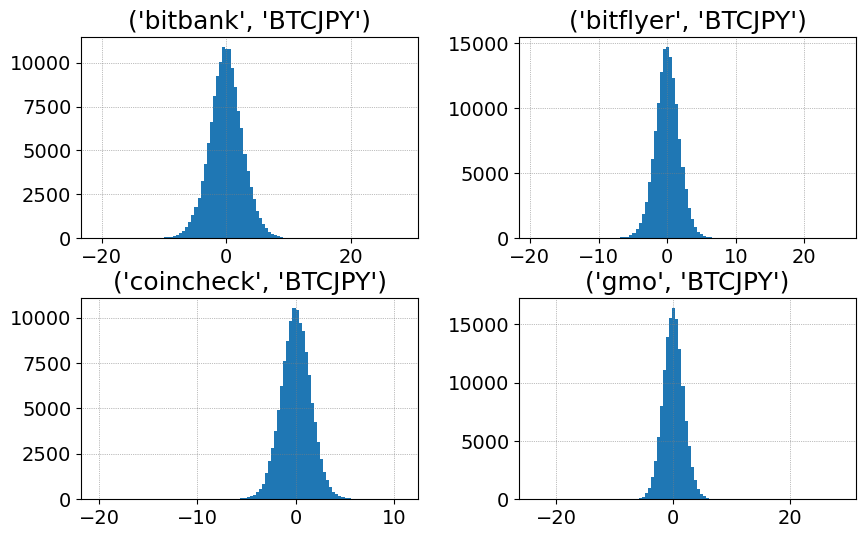

In [69]:
dev_roll.hist(bins=100);

In [70]:
dev_roll.quantile(q=[0.05, 0.95])

venue,bitbank,bitflyer,coincheck,gmo
sym,BTCJPY,BTCJPY,BTCJPY,BTCJPY
0.05,-4.325555,-2.918893,-2.524388,-2.866609
0.95,4.358843,2.862794,2.493972,2.913667


In [92]:
ret = pd.concat([
    close.shift(-6 * 30).div(close).sub(1).mul(1e4).stack(level=[0, 1]).to_frame("ret_30m"),
    close.shift(-6 * 10).div(close).sub(1).mul(1e4).stack(level=[0, 1]).to_frame("ret_10m"),
    close.shift(-6).div(close).sub(1).mul(1e4).stack(level=[0, 1]).to_frame("ret_1m"),
], axis=1)

In [96]:
sig = np.sign(dev_roll).mul(-1).mul(dev_roll.abs().ge(5)).stack(level=[0, 1]).to_frame("signal").query("signal != 0")
sig = sig.join(ret).dropna()

In [117]:
sig.groupby(["venue", "sym", "signal"]).agg(["count", "mean", "median", "std"]).style.format(precision=2)

<Axes: >

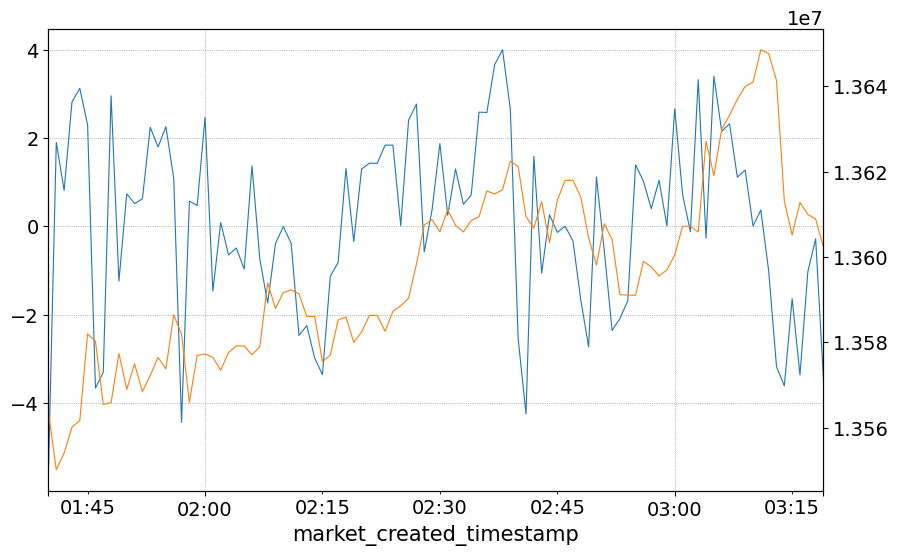

In [162]:
s, e = 100, 200
dev_roll.resample("1min").last().bitflyer.BTCJPY.iloc[s:e].plot()
close.loc[dev_roll.resample("1min").last().iloc[s:e].index].bitflyer.BTCJPY.plot(secondary_y=True)

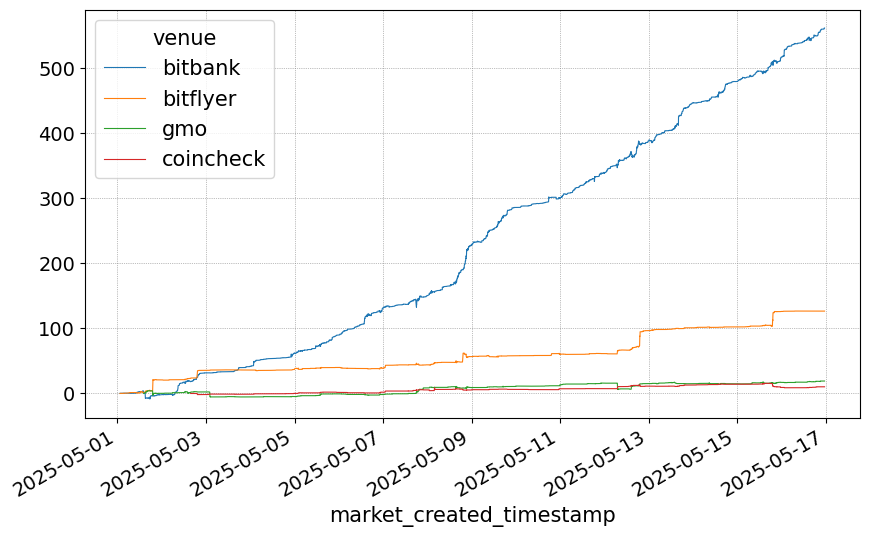

In [179]:
sig["pl_10m"] = sig.signal * sig.ret_10m
sig.pl_10m.unstack(level=[1]).reset_index(level=-1, drop=True).cumsum().div(1e2).ffill().plot();

/tmp/ipykernel_1615197/2532955296.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for c, s in sig.pl_10m.unstack(level=[1]).reset_index(level=-1, drop=True).cumsum().div(1e2).ffill().iteritems():


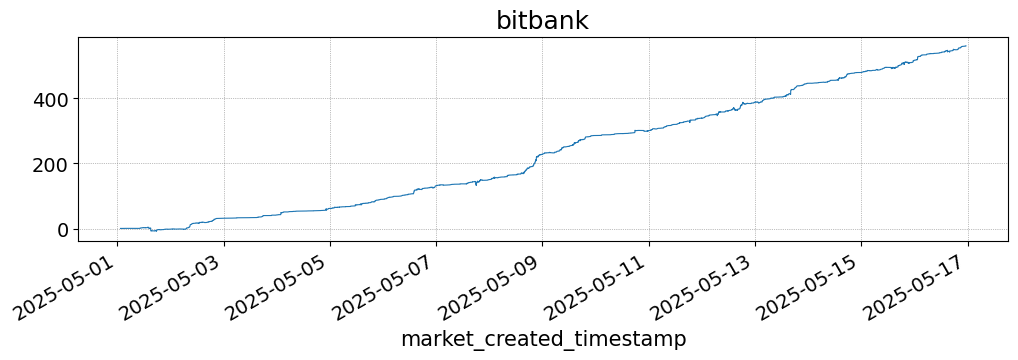

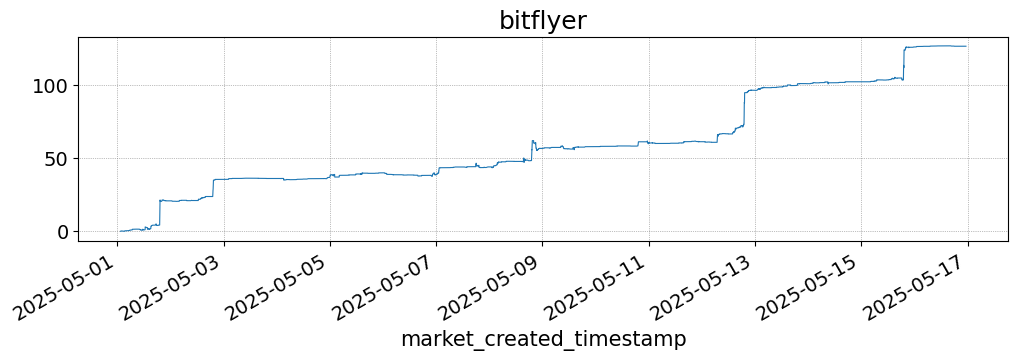

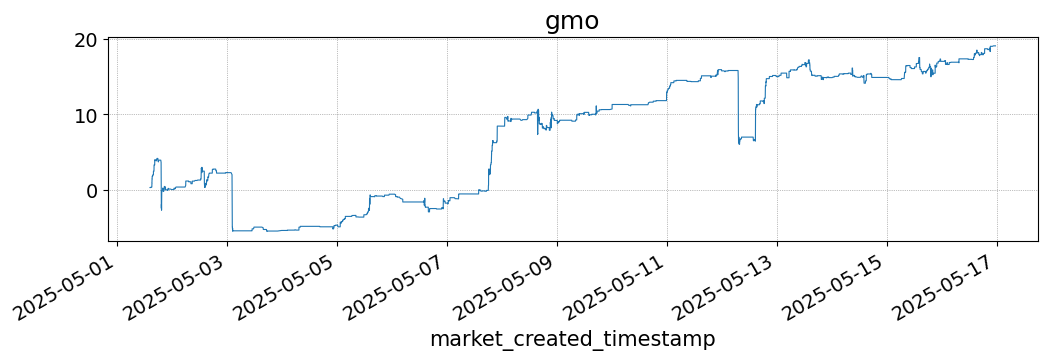

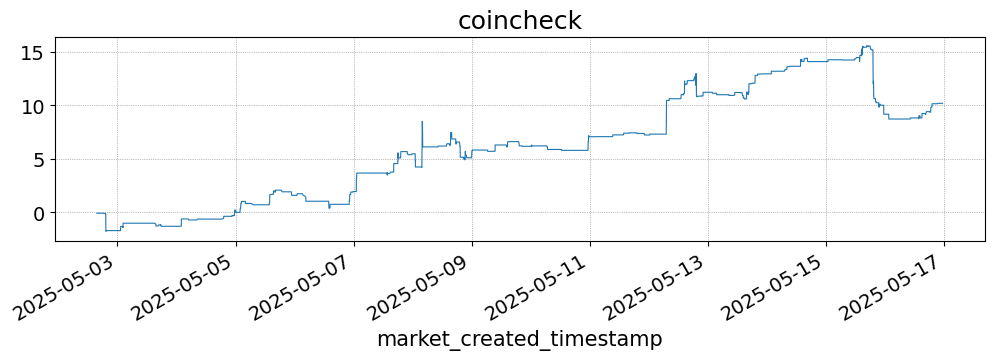

In [211]:
for c, s in sig.pl_10m.unstack(level=[1]).reset_index(level=-1, drop=True).cumsum().div(1e2).ffill().iteritems():
    plt.figure(figsize=(12, 3)); s.plot(title=c)

In [180]:
df = (
    dev_roll.bitflyer.BTCJPY.to_frame("dev")
    .join(close.bitflyer)
    .join(sig.pl_10m.unstack(level=[1]).reset_index(level=-1, drop=True).cumsum().bitflyer)
    .ffill()
)

In [201]:
df2 = (
    dev_roll.bitbank.BTCJPY.to_frame("dev")
    .join(close.bitbank)
    .join(sig.pl_10m.unstack(level=[1]).reset_index(level=-1, drop=True).cumsum().bitbank)
    .ffill()
)

<Axes: xlabel='market_created_timestamp'>

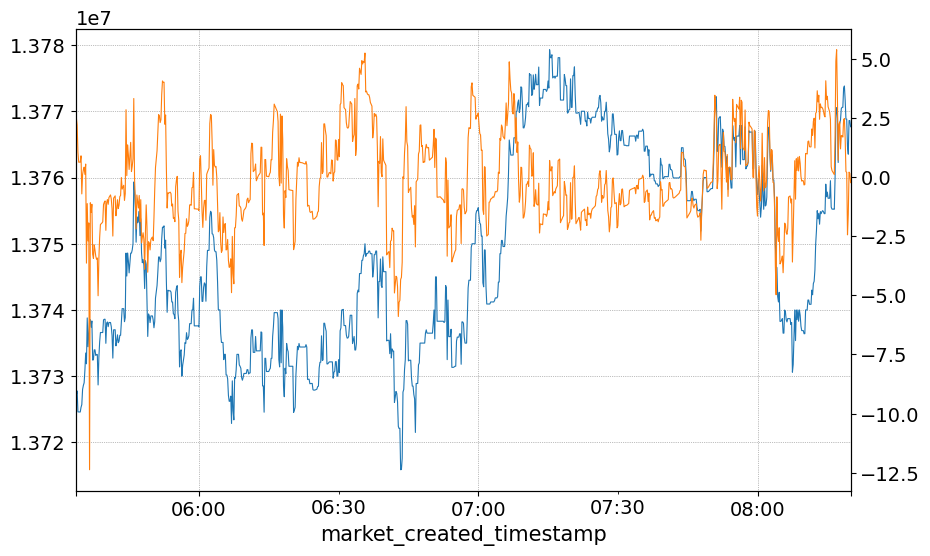

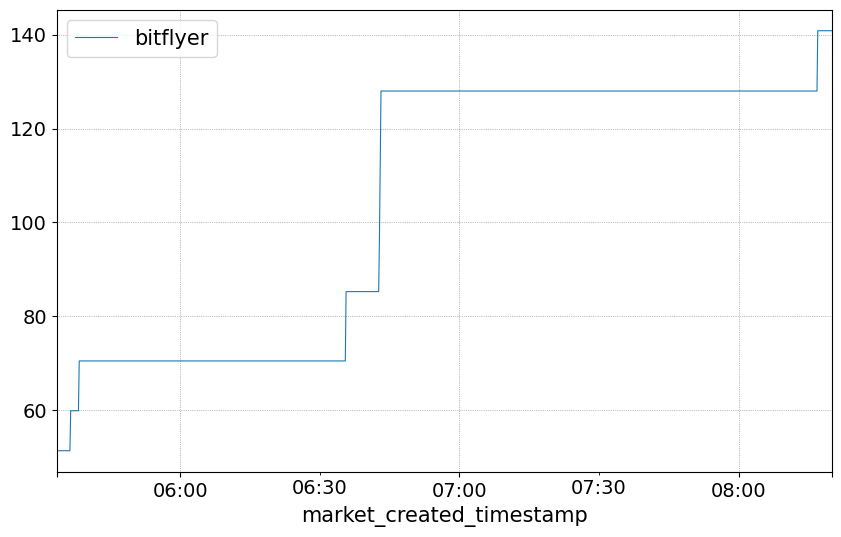

In [195]:
s, e = 2000, 3000
df.iloc[s:e].BTCJPY.plot()
df.iloc[s:e].dev.plot(secondary_y=True)
df.iloc[s:e][["bitflyer"]].plot()

<Axes: xlabel='market_created_timestamp'>

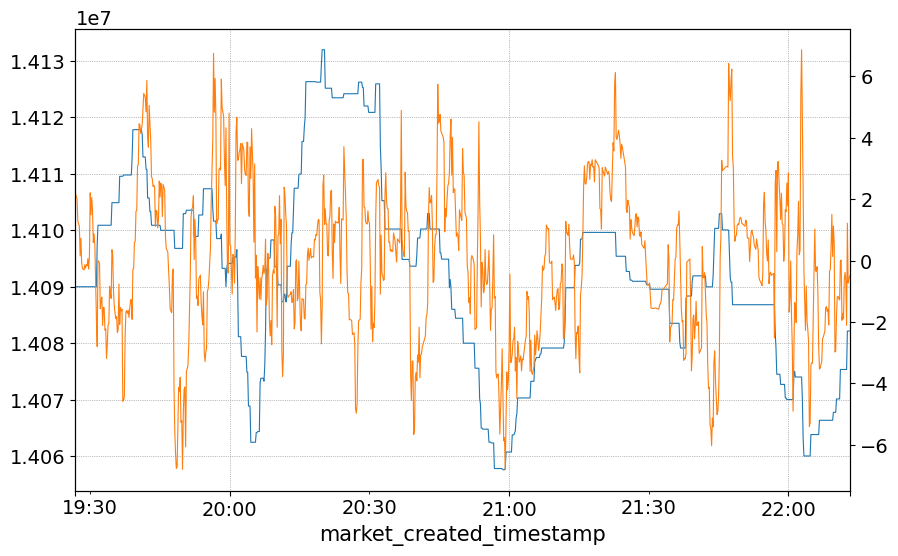

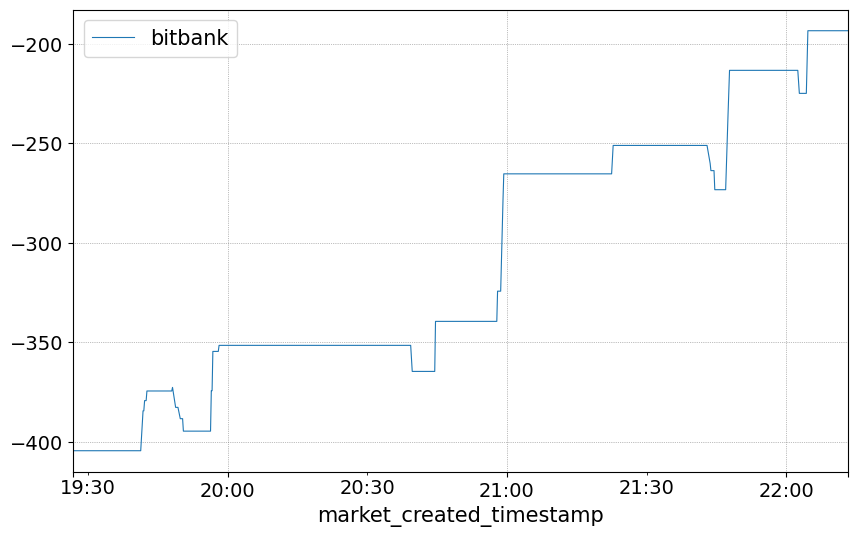

In [207]:
s, e = 7000, 8000
df2.iloc[s:e].BTCJPY.plot()
df2.iloc[s:e].dev.plot(secondary_y=True)
df2.iloc[s:e][["bitbank"]].plot()